In [15]:
import os
import argparse 
from sklearn import preprocessing
import numpy as np
from scipy.io import wavfile 
from hmmlearn import hmm
from python_speech_features import mfcc
import matplotlib.pyplot as plt

In [2]:
# Class to handle all HMM related processing
class HMMTrainer(object):
    def __init__(self, model_name='GaussianHMM', n_components=6, cov_type='diag', n_iter=1000):
        self.model_name = model_name
        self.n_components = n_components
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.models = []

        if self.model_name == 'GaussianHMM':
            self.model = hmm.GaussianHMM(n_components=self.n_components, 
                    covariance_type=self.cov_type, n_iter=self.n_iter)
        else:
            raise TypeError('Invalid model type')

    # X is a 2D numpy array where each row is 13D
    def train(self, X, len_x):
        np.seterr(all='ignore')
        self.models.append(self.model.fit(X, len_x))

    # Run the model on input data
    def get_score(self, input_data):
        return self.model.score(input_data)

In [ ]:
input_folder = "/home/thangnd/git/python_workspace/data/audio/"
labels = []
path_files = []
# Parse the input directory
for dirname in os.listdir(input_folder):
    # Get the name of the subfolder 
    subfolder = os.path.join(input_folder, dirname)
    if not os.path.isdir(subfolder): 
        continue
    # Extract the label
    label = subfolder[subfolder.rfind('/') + 1:]
    # Iterate through the audio files (leaving 1 file for testing in each class)
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-1]:
        labels.append(label)
    

In [3]:

hmm_models = []


# Parse the input directory
for dirname in os.listdir(input_folder):
    # Get the name of the subfolder 
    subfolder = os.path.join(input_folder, dirname)

    if not os.path.isdir(subfolder): 
        continue

    # Extract the label
    label = subfolder[subfolder.rfind('/') + 1:]

    # Initialize variables
    X = np.array([])
    len_x = np.array([])
    y_words = []

    # Iterate through the audio files (leaving 1 file for testing in each class)
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-1]:
        labels.append(dirname)
        # Read the input file
        filepath = os.path.join(subfolder, filename)
        path_files.append(filepath)
        sampling_freq, audio = wavfile.read(filepath)

        # Extract MFCC features
        mfcc_features = mfcc(audio, sampling_freq)
        # Append to the variable X
        if len(X) == 0:
            X = mfcc_features
            len_x = mfcc_features.shape[0]
        else:
            X = np.append(X, mfcc_features, axis=0)
            len_x = np.append(len_x, mfcc_features.shape[0])
        # Append the label
        y_words.append(label)

    print ('X.shape =', X.shape)
    print ('len_x = ', len_x)
    # Train and save HMM model
    hmm_trainer = HMMTrainer()
    hmm_trainer.train(X, len_x)
    hmm_models.append((hmm_trainer, label))
    hmm_trainer = None

/home/thangnd/python_env/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


X.shape = (1081, 13)
len_x =  [73 77 74 83 74 80 73 78 81 67 85 73 86 77]
X.shape = (795, 13)
len_x =  [62 56 56 59 56 56 54 55 55 57 59 55 61 54]
X.shape = (705, 13)
len_x =  [57 55 52 45 45 54 54 50 43 57 42 48 51 52]
X.shape = (556, 13)
len_x =  [35 42 38 42 40 42 38 33 43 43 43 40 36 41]
X.shape = (916, 13)
len_x =  [66 64 61 67 67 67 64 73 63 61 62 69 63 69]
X.shape = (598, 13)
len_x =  [42 40 43 45 45 41 43 43 47 37 43 41 47 41]
X.shape = (552, 13)
len_x =  [43 38 35 43 44 37 36 41 38 43 38 42 37 37]


In [10]:
pred_labels = []
# Classify input data
for input_file in path_files:
    # Read input file
    sampling_freq, audio = wavfile.read(input_file)

    # Extract MFCC features
    mfcc_features = mfcc(audio, sampling_freq)

    # Define variables
    max_score = float('-inf')
    output_label = None

    # Iterate through all HMM models and pick 
    # the one with the highest score
    for item in hmm_models:
        hmm_model, label = item
        score = hmm_model.get_score(mfcc_features)
        if score > max_score:
            max_score = score
            output_label = label
    pred_labels.append(output_label)

/home/thangnd/python_env/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


Text(0.5,0,'Predicted label')

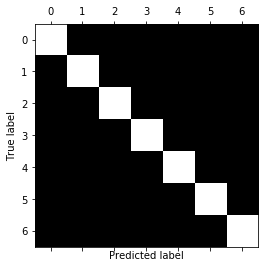

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, pred_labels)
plt.matshow(cm, cmap='gray')

plt.ylabel('True label')
plt.xlabel('Predicted label')